In [2]:
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
from nltk import pad_sequence

## Dataset

In [4]:
# load dataset

df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')

In [5]:
# training set

df_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
# test set (no labels)

df_test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [7]:
# attributes in the dataset

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


Number of Instances in Each Class:

label
1    10413
0    10387
Name: count, dtype: int64


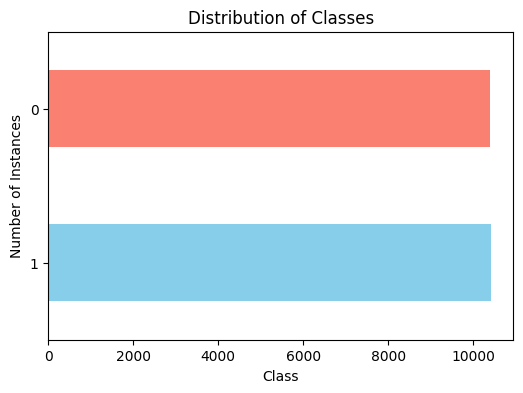

In [8]:
print("Number of Instances in Each Class:\n")
print(df_train['label'].value_counts())

plt.figure(figsize=(6, 4))
df_train['label'].value_counts().plot(kind='barh', color=['skyblue', 'salmon'])
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=0)
plt.show()

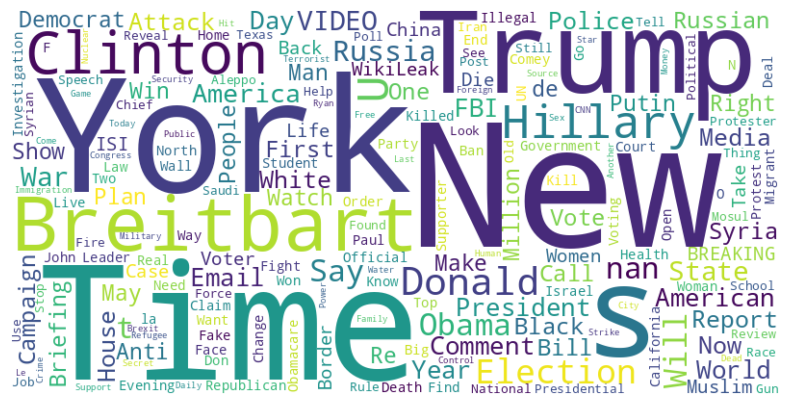

In [10]:
# Word cloud
from wordcloud import WordCloud

titles_text = ' '.join(df_train['title'].astype(str))

wordcloud = WordCloud(width=800, height=400, collocations = False,
                      max_font_size = 180, background_color='white').generate(titles_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
# Data Preprocessing

def preprocess_text(text):

    text = text.lower()
    
    # remove special characters, URLs, and numbers
    text = re.sub(r'https?://\S+|www\.\S+|[^a-zA-Z\s]', '', text)
    
    # tokenization
    tokens = word_tokenize(text)
    
    # remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # lemmatization (using WordNet Lemmatizer)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

In [12]:
df_train['text'] = df_train['text'].astype(str).apply(preprocess_text)
df_train

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,house dem aide didnt even see comeys letter ja...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,ever get feeling life circle roundabout rather...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,truth might get fired october tension intellig...,1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,video civilian killed single u airstrike ident...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,print iranian woman sentenced six year prison ...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,rapper unloaded black celebrity met donald tru...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,green bay packer lost washington redskin week ...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,macys today grew union several great name amer...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,nato russia hold parallel exercise balkan pres...,1


In [13]:
df_train.isna().sum()

id           0
title      558
author    1957
text         0
label        0
dtype: int64

In [23]:
# training and testing sets

X = df_train['text']
y = df_train['label']

# Split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)


Training Set Shape: (16640,)
Test Set Shape: (4160,)
